## NBA Home Court Advantage

### Part 4: Which Box Score Statistics Contribute to Home Court Advantage?

If the home team has a higher win probability, that advantage should be evident in at least some of the box score statistics. Home court advantage could result from better offense, better defense, or a mix of the two.

In this notebook, we'll examine how basic box score statistics vary between home and away games.

We'll continue to use the games from the 1996-97 through 2016-17 NBA regular seasons as our data set.

In [1]:
import numpy as np
import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.options.display.float_format = '{:.3f}'.format

In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import rgb2hex
import seaborn as sns
sns.set()
sns.set_context('notebook')
plt.style.use('ggplot')

In [3]:
from scipy import stats

In [4]:
from pathlib import Path

In [5]:
PROJECT_DIR = Path.cwd().parent / 'basketball' / 'nba'
DATA_DIR = PROJECT_DIR / 'data' / 'prepared'
DATA_DIR.mkdir(exist_ok=True, parents=True)

In [6]:
def load_nba_historical_matchups(input_dir):
    """Load pickle file of NBA matchups prepared for analytics."""
    PKLFILENAME = 'stats_nba_com-matchups-1996_97-2016_17.pkl'
    pklfile = input_dir.joinpath(PKLFILENAME)
    return pd.read_pickle(pklfile)

In [7]:
matchups = load_nba_historical_matchups(DATA_DIR)
matchups.shape

(26787, 41)

In [8]:
seasons = sorted(list(matchups['season'].unique()))
len(seasons)

21

In [9]:
def prepare_regular_season(matchups):
    df = matchups.copy()
    df = df[df['season_type'] == 'regular']
    return df

In [10]:
reg = prepare_regular_season(matchups)
reg.shape

(24797, 41)

In [11]:
teams = sorted(list(reg['team_curr_h'].unique()))
len(teams)

30

### Aggregating the Data

We are going to try to identify which team box score statistics improve at home compared to on the road. In order to do this properly, we need to isolate the impact of location (home versus away) from the match up itself. Otherwise, the variation created by differences in opponent quality will swamp the impact of home court.

To do this, we are going to group box score statistics by season, team, and opponent. Grouping in this way will allow us to control for the variation in team quality in different seasons. It will also allow us to control for the different quanlity of various opponents.

Within this grouping, we will separate the home games from the away games, and get the average box score statistics for each. Then, we can subtract the average away game statistics from the average home game statistics. The difference between the grouped home and away statistics will be our measure of how team performance improves just by virtue of playing at home.

The below Python code uses `pandas` to implement this idea. Also, note that we are going to scale the statistics for a standard 48-minute game. We will also compute shooting percentages for field goals, three-pointers, and free throws.

In [12]:
HOME = 'H'
AWAY = 'A'

In [13]:
def aggregation(group, home_away):
    suffix = '_h' if home_away == HOME else '_a'
    # Get the home or away columns and strip off the suffix
    stat_cols = [col[:-2] for col in group.columns if suffix in col and 'team' not in col]
    # Scale the stats for a 48-minute game and get the group average
    result = {}
    for col in stat_cols:
        result[col] = (group[col+suffix] / group['min'] * 48.0).mean()
    # Compute shooting percentages for the group
    pct_cols = ['fg', 'fg3', 'ft']
    for col in pct_cols:
        result[col+'_pct'] = (100.0 * group[col+'m'+suffix] / group[col+'a'+suffix]).mean()
    return pd.Series(result, index=list(result.keys()))

The above function computes the average statistics for each season, team and opponent grouping, scaled to a standard 48-minute game. It will also compute the shooting percentages. Notice that this function doesn't do the home versus away subtraction. That will come later.

The function below does the actual grouping, and calls the above function for each group. It also keeps track of how many games are in each group.

In [14]:
def aggregate_stats(data, home_away):
    suffix = '_h' if home_away == HOME else '_a'
    other_suffix = '_a' if home_away == HOME else '_h'
    team = 'team_curr' + suffix
    opponent = 'team_curr' + other_suffix
    # Apply the aggregation by season, team and opponent
    df = data.groupby(['season', team, opponent]).apply(aggregation, home_away)
    # Add a count of the number of games in this group
    df['games'] = data.groupby(['season', team, opponent]).size()
    df = df.reset_index().rename(columns={team: 'team', opponent: 'opponent'})
    df = df.set_index(['season', 'team', 'opponent'])
    # Drop NA rows (i.e., team vs itself, team vs CHA prior to expansion)
    cols = [col for col in df.columns if col != 'games']
    return df.dropna()[['games']+cols]

Let's do the grouping and aggregation for the home games first.

In [15]:
home_df = aggregate_stats(reg, HOME)
home_df.shape

(17290, 18)

There are 17,290 distinct groups of home games by season, team and opponent.

In [16]:
home_df.head()

games     pts    fgm    fga   fg3m   fg3a    ftm  \
season  team opponent                                                     
1996-97 ATL  BKN       2.000 109.000 37.000 76.000 12.000 26.500 23.000   
             BOS       2.000 100.000 38.500 84.000  8.000 25.000 15.000   
             CHI       2.000  98.000 34.500 81.000  7.500 24.500 21.500   
             CLE       2.000  90.000 31.000 66.500  7.000 21.000 21.000   
             DAL       1.000  93.000 37.000 72.000 11.000 24.000  8.000   

                         fta   oreb   dreb    ast    tov    stl   blk     pf  \
season  team opponent                                                          
1996-97 ATL  BKN      28.000 10.500 30.500 22.000 16.000  9.000 5.000 19.000   
             BOS      19.000 17.500 30.000 22.500 17.000 10.000 7.500 19.000   
             CHI      24.500 15.500 28.500 13.500 13.000  7.500 4.500 19.500   
             CLE      24.000  8.000 25.000 19.500 15.000  6.500 5.000 19.000   
             DAL      15.000  9.000 29.000 22.000 13.000  9.000 3.000 13.000   

                       fg_pct  fg3_pct  ft_pct  
season  team opponent                           
1996-97 ATL  BKN       48.710   45.214  82.143  
             BOS       45.828   34.225  78.333  
             CHI       42.593   30.303  85.646  
             CLE       47.368   33.409  86.933  
             DAL       51.389   45.833  53.333

Let's check to make sure didn't drop any games from our data set during the aggregation.

In [17]:
home_df['games'].sum()

24797.0

The correct number of games got picked up in the aggregation. Since the aggregation takes a while, let's save the results in a CSV file in case we want to pick up this analysis on a different occasion.

In [18]:
csvfile = DATA_DIR.joinpath('stats_nba_com-agg_matchup_box_scores-home-1996_97-2016_17.csv')
home_df.to_csv(csvfile, index=True, float_format='%g')

Now we can perform the same steps for the away games.

In [19]:
away_df = aggregate_stats(reg, AWAY)
away_df.shape

(17290, 18)

In [20]:
away_df.head()

games     pts    fgm    fga   fg3m   fg3a    ftm  \
season  team opponent                                                     
1996-97 ATL  BKN       2.000  93.500 35.500 88.000  8.000 30.500 14.500   
             BOS       2.000  99.500 38.000 81.000 10.000 26.000 13.500   
             CHI       2.000  74.000 27.000 79.500  5.500 18.500 14.500   
             CLE       2.000  78.000 28.500 66.500  7.000 21.500 14.000   
             DAL       1.000 109.000 40.000 74.000 19.000 27.000 10.000   

                         fta   oreb   dreb    ast    tov    stl   blk     pf  \
season  team opponent                                                          
1996-97 ATL  BKN      17.500 17.000 28.000 18.000 12.500  8.500 5.000 15.000   
             BOS      24.500 12.500 33.000 28.000 24.000 11.500 6.500 19.500   
             CHI      19.000 14.500 25.500 12.000 16.000  9.000 4.000 16.000   
             CLE      18.000  9.000 28.500 18.500 13.500  7.000 5.000 17.500   
             DAL      22.000 12.000 37.000 26.000 15.000  6.000 9.000 14.000   

                       fg_pct  fg3_pct  ft_pct  
season  team opponent                           
1996-97 ATL  BKN       40.413   26.407  81.250  
             BOS       46.558   38.370  55.051  
             CHI       33.972   28.205  77.451  
             CLE       43.617   32.717  76.190  
             DAL       54.054   70.370  45.455

In [21]:
away_df['games'].sum()

24797.0

In [22]:
csvfile = DATA_DIR.joinpath('stats_nba_com-agg_matchup_box_scores-away-1996_97-2016_17.csv')
away_df.to_csv(csvfile, index=True, float_format='%g')

### Combining the Home and Away Data

Now that we have aggregated the home games and the away games, we need to combine the information. Remember, our goal is to subtract each team's home game performance from the same team's away game performance, grouped by season and opposing team.

We can use the `pandas` [`join()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) method to accomplish this. We will add a suffix to each of the data columns to keep trach of which statistics came from the home games, and which came from the away games.

In [23]:
df = home_df.join(away_df, how='outer', lsuffix='_h', rsuffix='_a')
df.shape

(17554, 36)

#### Checking the Number of Rows

Notice that the number of rows in the combined `DataFrame` is larger than the number of rows in each of the home and away `DataFrame` objects. That means we need to look more closely at whether the `join()` method created any rows with missing or null data. We will do that shortly. First, let's take a look at the combined data.

In [24]:
df.head()

games_h   pts_h  fgm_h  fga_h  fg3m_h  fg3a_h  ftm_h  \
season  team opponent                                                         
1996-97 ATL  BKN         2.000 109.000 37.000 76.000  12.000  26.500 23.000   
             BOS         2.000 100.000 38.500 84.000   8.000  25.000 15.000   
             CHI         2.000  98.000 34.500 81.000   7.500  24.500 21.500   
             CLE         2.000  90.000 31.000 66.500   7.000  21.000 21.000   
             DAL         1.000  93.000 37.000 72.000  11.000  24.000  8.000   

                       fta_h  oreb_h  dreb_h  ast_h  tov_h  stl_h  blk_h  \
season  team opponent                                                      
1996-97 ATL  BKN      28.000  10.500  30.500 22.000 16.000  9.000  5.000   
             BOS      19.000  17.500  30.000 22.500 17.000 10.000  7.500   
             CHI      24.500  15.500  28.500 13.500 13.000  7.500  4.500   
             CLE      24.000   8.000  25.000 19.500 15.000  6.500  5.000   
             DAL      15.000   9.000  29.000 22.000 13.000  9.000  3.000   

                        pf_h  fg_pct_h  fg3_pct_h  ft_pct_h  games_a   pts_a  \
season  team opponent                                                          
1996-97 ATL  BKN      19.000    48.710     45.214    82.143    2.000  93.500   
             BOS      19.000    45.828     34.225    78.333    2.000  99.500   
             CHI      19.500    42.593     30.303    85.646    2.000  74.000   
             CLE      19.000    47.368     33.409    86.933    2.000  78.000   
             DAL      13.000    51.389     45.833    53.333    1.000 109.000   

                       fgm_a  fga_a  fg3m_a  fg3a_a  ftm_a  fta_a  oreb_a  \
season  team opponent                                                       
1996-97 ATL  BKN      35.500 88.000   8.000  30.500 14.500 17.500  17.000   
             BOS      38.000 81.000  10.000  26.000 13.500 24.500  12.500   
             CHI      27.000 79.500   5.500  18.500 14.500 19.000  14.500   
             CLE      28.500 66.500   7.000  21.500 14.000 18.000   9.000   
             DAL      40.000 74.000  19.000  27.000 10.000 22.000  12.000   

                       dreb_a  ast_a  tov_a  stl_a  blk_a   pf_a  fg_pct_a  \
season  team opponent                                                        
1996-97 ATL  BKN       28.000 18.000 12.500  8.500  5.000 15.000    40.413   
             BOS       33.000 28.000 24.000 11.500  6.500 19.500    46.558   
             CHI       25.500 12.000 16.000  9.000  4.000 16.000    33.972   
             CLE       28.500 18.500 13.500  7.000  5.000 17.500    43.617   
             DAL       37.000 26.000 15.000  6.000  9.000 14.000    54.054   

                       fg3_pct_a  ft_pct_a  
season  team opponent                       
1996-97 ATL  BKN          26.407    81.250  
             BOS          38.370    55.051  
             CHI          28.205    77.451  
             CLE          32.717    76.190  
             DAL          70.370    45.455

Notice that this `DataFrame` uses a `pandas` [`MultiIndex`](https://pandas.pydata.org/pandas-docs/stable/advanced.html) structure for the 3 index columns. Here is an example of how to access a particular match up for a particular season.

In [25]:
df.loc['2016-17', ['WAS', 'UTA'], ['WAS', 'UTA']]

games_h  pts_h  fgm_h  fga_h  fg3m_h  fg3a_h  ftm_h  \
season  team opponent                                                        
2016-17 UTA  WAS         1.000 95.000 33.000 72.000  10.000  25.000 19.000   
        WAS  UTA         1.000 92.000 37.000 87.000   8.000  22.000 10.000   

                       fta_h  oreb_h  dreb_h  ast_h  tov_h  stl_h  blk_h  \
season  team opponent                                                      
2016-17 UTA  WAS      31.000   7.000  35.000 20.000 12.000  9.000  7.000   
        WAS  UTA      13.000   6.000  22.000 21.000 16.000 16.000  1.000   

                        pf_h  fg_pct_h  fg3_pct_h  ft_pct_h  games_a   pts_a  \
season  team opponent                                                          
2016-17 UTA  WAS      18.000    45.833     40.000    61.290    1.000 102.000   
        WAS  UTA      27.000    42.529     36.364    76.923    1.000  88.000   

                       fgm_a  fga_a  fg3m_a  fg3a_a  ftm_a  fta_a  oreb_a  \
season  team opponent                                                       
2016-17 UTA  WAS      34.000 72.000  11.000  24.000 23.000 32.000   9.000   
        WAS  UTA      35.000 87.000   5.000  17.000 13.000 16.000  14.000   

                       dreb_a  ast_a  tov_a  stl_a  blk_a   pf_a  fg_pct_a  \
season  team opponent                                                        
2016-17 UTA  WAS       41.000 18.000 25.000 10.000 11.000 19.000    47.222   
        WAS  UTA       31.000 12.000 15.000  8.000  1.000 23.000    40.230   

                       fg3_pct_a  ft_pct_a  
season  team opponent                       
2016-17 UTA  WAS          45.833    71.875  
        WAS  UTA          29.412    81.250

The first row in the above example are Utah's statistics, when they played Washington during the 2016-17 regular season. The columns ending in `_h` are Utah's home statistics, and the columns ending in `_a` are their away statistics. We can see from the games columns that the Jazz and the Wizards played 1 game in Salt Lake City and 1 game in Washington, D.C. during that season.

The second row is the same match up, but with Washington's statistics.

Let's just double-check that we still have all the relevant regular season games captured in this `DataFrame`.

In [26]:
df['games_h'].sum()

24797.0

In [27]:
df['games_a'].sum()

24797.0

#### Understanding the Number of Rows

All the games are there. But, as we noticed above, extra rows were created in this `DataFrame` when we merged the home and away game data. Let's check to see how many rows have at least one null or missing value.

In [28]:
len(df[df.isnull().any(axis=1)])

528

Bingo. The joined `DataFrame` had 264 extra rows compared to the original home and away `DataFrame` objects (264 = 17,554 - 17,290).

And, 528 is double 264. This means that there are some match ups in particular seasons that didn't have both home and away games. The reason the 264 is doubled is that for one match up row in the table, the home game columns are null, and in the other row, the away game columsn are null.

Let's take a look at the rows that have missing values.

In [29]:
df[df.isnull().any(axis=1)].head()

games_h  pts_h  fgm_h  fga_h  fg3m_h  fg3a_h  ftm_h  \
season  team opponent                                                        
1998-99 ATL  DAL           nan    nan    nan    nan     nan     nan    nan   
             HOU           nan    nan    nan    nan     nan     nan    nan   
             LAC           nan    nan    nan    nan     nan     nan    nan   
             MEM         1.000 84.000 30.000 78.000   2.000   9.000 22.000   
             PHX         1.000 93.000 31.000 74.000   9.000  24.000 22.000   

                       fta_h  oreb_h  dreb_h  ast_h  tov_h  stl_h  blk_h  \
season  team opponent                                                      
1998-99 ATL  DAL         nan     nan     nan    nan    nan    nan    nan   
             HOU         nan     nan     nan    nan    nan    nan    nan   
             LAC         nan     nan     nan    nan    nan    nan    nan   
             MEM      26.000  18.000  27.000 11.000 15.000 10.000  6.000   
             PHX      24.000  15.000  37.000 18.000 19.000  7.000  6.000   

                        pf_h  fg_pct_h  fg3_pct_h  ft_pct_h  games_a   pts_a  \
season  team opponent                                                          
1998-99 ATL  DAL         nan       nan        nan       nan    1.000  85.000   
             HOU         nan       nan        nan       nan    1.000  93.000   
             LAC         nan       nan        nan       nan    1.000 103.000   
             MEM      26.000    38.462     22.222    84.615      nan     nan   
             PHX      21.000    41.892     37.500    91.667      nan     nan   

                       fgm_a  fga_a  fg3m_a  fg3a_a  ftm_a  fta_a  oreb_a  \
season  team opponent                                                       
1998-99 ATL  DAL      32.000 86.000   4.000  16.000 17.000 26.000  18.000   
             HOU      38.000 92.000   4.000  10.000 13.000 17.000  15.000   
             LAC      40.000 74.000   2.000   7.000 21.000 24.000   9.000   
             MEM         nan    nan     nan     nan    nan    nan     nan   
             PHX         nan    nan     nan     nan    nan    nan     nan   

                       dreb_a  ast_a  tov_a  stl_a  blk_a   pf_a  fg_pct_a  \
season  team opponent                                                        
1998-99 ATL  DAL       31.000 18.000 12.000  5.000  9.000 17.000    37.209   
             HOU       26.000 18.000  4.000 10.000  8.000 18.000    41.304   
             LAC       32.000 23.000  8.000  7.000  5.000 19.000    54.054   
             MEM          nan    nan    nan    nan    nan    nan       nan   
             PHX          nan    nan    nan    nan    nan    nan       nan   

                       fg3_pct_a  ft_pct_a  
season  team opponent                       
1998-99 ATL  DAL          25.000    65.385  
             HOU          40.000    76.471  
             LAC          28.571    87.500  
             MEM             nan       nan  
             PHX             nan       nan

Let's see which seasons don't have balanced match ups between home and away games.

In [30]:
df[df.isnull().any(axis=1)].groupby(['season']).size()

season
1998-99    168
2011-12    360
dtype: int64

This makes sense. These are the seasons that experienced [lockouts](https://en.wikipedia.org/wiki/NBA_lockout) and therefore didn't have a normal schedule.

In our analysis, we need to subtract the away game aggregate statistics from the home game aggregate statistics. So, we'll have to drop these rows that have null values.

### Home versus Away Difference

Now we are ready to do the subtract to create the home court advantage analysis.

In [31]:
def matchup_home_edge(df):
    stat_cols = [col[:-2] for col in df.columns if '_h' in col and 'games' not in col]
    df = df.copy().dropna()
    for col in stat_cols:
        df[col] = df[col+'_h'] - df[col+'_a']
    df['games'] = df['games_h'] + df['games_a']
    df['games'] = df['games'].astype(int)
    return df[['games']+stat_cols]

In [32]:
hca = matchup_home_edge(df)
hca.head()

games     pts    fgm     fga   fg3m   fg3a    ftm  \
season  team opponent                                                      
1996-97 ATL  BKN           4  15.500  1.500 -12.000  4.000 -4.000  8.500   
             BOS           4   0.500  0.500   3.000 -2.000 -1.000  1.500   
             CHI           4  24.000  7.500   1.500  2.000  6.000  7.000   
             CLE           4  12.000  2.500   0.000  0.000 -0.500  7.000   
             DAL           2 -16.000 -3.000  -2.000 -8.000 -3.000 -2.000   

                         fta   oreb   dreb    ast    tov    stl    blk     pf  \
season  team opponent                                                           
1996-97 ATL  BKN      10.500 -6.500  2.500  4.000  3.500  0.500  0.000  4.000   
             BOS      -5.500  5.000 -3.000 -5.500 -7.000 -1.500  1.000 -0.500   
             CHI       5.500  1.000  3.000  1.500 -3.000 -1.500  0.500  3.500   
             CLE       6.000 -1.000 -3.500  1.000  1.500 -0.500  0.000  1.500   
             DAL      -7.000 -3.000 -8.000 -4.000 -2.000  3.000 -6.000 -1.000   

                       fg_pct  fg3_pct  ft_pct  
season  team opponent                           
1996-97 ATL  BKN        8.297   18.807   0.893  
             BOS       -0.730   -4.146  23.283  
             CHI        8.621    2.098   8.195  
             CLE        3.752    0.692  10.742  
             DAL       -2.665  -24.537   7.879

Notice how we differenced the home and away statistics and returned a simpler `DataFrame`. The original home and away `DataFrame` objects are unchanged, of course.

#### Home Court Impact on Box Score Statistics

Now let's take a look at the impact of home court on box score statistics.

We'll separate out the statistics by type, either scoring or other.

In [33]:
stats_cols = [col for col in hca.columns if col not in ['games']]
scoring_cols = [col for col in stats_cols if any(s in col for s in ['pts', 'fg', 'ft'])]
other_cols = [col for col in stats_cols if col not in scoring_cols]

First, let's see how many games typically occurred between a particular pair of teams in each season.

In [34]:
hca['games'].describe()

count   17026.000
mean        2.882
std         0.927
min         2.000
25%         2.000
50%         3.000
75%         4.000
max         5.000
Name: games, dtype: float64

We see that each match up in our data set occurred between 2 and 5 times per season, with a typical value of 3 games. We know from the [rules of the NBA season](https://www.nbastuffer.com/analytics101/how-the-nba-schedule-is-made/) that teams in the same Division play more games, so this distribution makes sense.

Now, let's look at the scoring and other statistics.

In [35]:
hca[scoring_cols].describe()

,pts,fgm,fga,fg3m,fg3a,ftm,fta,fg_pct,fg3_pct,ft_pct
count,17026.000,17026.000,17026.000,17026.000,17026.000,17026.000,17026.000,17026.000,17026.000,17026.000
mean,3.099,1.071,0.166,0.154,0.001,0.803,0.985,1.225,0.883,0.279
std,12.508,5.483,7.373,3.235,5.374,7.151,8.752,6.618,15.459,12.067
min,-50.000,-21.000,-33.000,-18.000,-26.000,-33.000,-41.000,-28.482,-80.000,-56.618
25%,-5.000,-2.500,-4.696,-2.000,-3.500,-4.000,-4.788,-3.092,-8.772,-7.585
50%,3.000,1.000,0.000,0.000,0.000,1.000,1.000,1.189,0.739,0.274
75%,11.000,4.500,5.000,2.000,3.500,5.500,6.500,5.467,10.464,8.036
max,55.000,23.000,32.000,16.000,24.000,29.000,44.000,29.252,72.143,52.941


In [36]:
hca[other_cols].describe()

,oreb,dreb,ast,tov,stl,blk,pf
count,17026.000,17026.000,17026.000,17026.000,17026.000,17026.000,17026.000
mean,0.374,1.057,1.666,-0.373,0.119,0.639,-0.532
std,4.653,5.825,5.680,4.501,3.418,3.025,4.920
min,-23.000,-26.000,-20.000,-22.000,-14.500,-12.085,-20.500
25%,-2.613,-2.802,-2.000,-3.083,-2.000,-1.000,-4.000
50%,0.500,1.000,1.513,-0.415,0.000,0.500,-0.500
75%,3.293,5.000,5.308,2.500,2.130,2.500,2.826
max,29.000,26.000,31.000,18.000,16.000,16.000,20.943


#### Scoring

If you look at the `pts` column, you will see that the same 3.1 point home court advantage emerges from our aggregated data.

Looking at that same column, you will also see that there is a lot of variation around that average. Remember, the data we're looking at are match ups within a particular season. The point differentials between the same two teams is not very consistent, even within the same season.

Let's plot the point differential.

In [37]:
def get_bins(s):
    mins = s.min()
    maxs = s.max()
    return np.arange(2*(round(mins/2)-1), 2*(round(maxs/2)+2), 2)

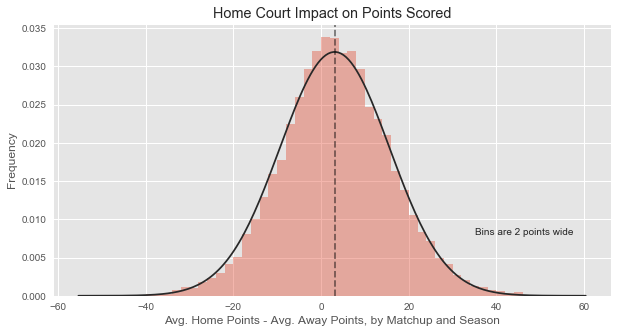

In [38]:
fig, ax = plt.subplots(figsize=(10, 5))
# Plot points distribution
data = hca['pts']
ax = sns.distplot(data, bins=get_bins(data), kde=False, fit=stats.norm, ax=ax)
ax.set_xlabel('Avg. Home Points - Avg. Away Points, by Matchup and Season')
ax.set_ylabel('Frequency')
ax.set_title('Home Court Impact on Points Scored')
ax.text(x=35, y=0.008, s='Bins are 2 points wide')
ax.axvline(x=data.mean(), linestyle='--', alpha=0.5, color='black')
plt.show()

The plot shows that a normal distribution fits the aggregated data relatively well. Nothing really stands out from the plot. Even so, the average impact of 3.1 points looks relatively small compared to the noisiness of the data.

#### Better Shooting Isn't the Whole Story

It's hard to pinpoint exactly how home court advantage translates into superior scoring. Field goal percentage goes up by about 1.2% on average, and three-point shooting percentage goes up by about 0.9% on average.

These modest improvements in scoring percentage are pointing in the right direction, but aren't sufficient to clearly explain the magnitude of NBA home court advantage.

#### Other Statistics

If you look at the other statistics, you will see that rebounding improves, _and_ assists improve, _and_ turnovers improve, _and_ steals improve, _and_ blocks improve, _and_ personal fouls called against the team improve. Of course, you wouldn't expect statistics like blocks and personal fouls to directly benefit scoring.

The overall message is: teams really do play better at home, and the benefit shows up in a lot of statistics. We will have to dig deeper in future analysis to try to understand better what is going on.

#### Box Score Variation by Team

To conclude, let's look at how these same statistics vary by team, aggregated over the course of the 21 complete regular seasons.

In [39]:
cols = ['pts', 'fg_pct', 'fg3_pct', 'ft_pct',] + other_cols

In [40]:
hca.groupby('team')[cols].mean().sort_values(by='pts', ascending=False)

,pts,fg_pct,fg3_pct,ft_pct,oreb,dreb,ast,tov,stl,blk,pf
team,,,,,,,,,,,
DEN,4.579,0.992,1.410,-0.086,0.199,1.757,3.591,-0.775,-0.114,1.839,0.169
ATL,4.186,1.738,0.709,-0.024,0.502,0.786,1.946,-0.573,-0.066,-0.248,-0.134
WAS,4.140,1.681,1.037,1.774,0.296,0.498,1.411,-0.436,0.376,0.363,-0.669
SAC,4.138,1.372,1.734,-0.042,0.532,1.070,0.226,-0.245,-0.182,0.312,-0.269
GSW,4.066,1.959,0.966,-0.138,0.787,1.279,3.084,-0.202,0.143,0.441,-0.482
POR,4.039,1.505,0.987,0.097,0.590,0.708,2.206,-0.418,0.218,-0.290,-0.770
DAL,3.724,1.120,1.302,0.179,0.986,1.367,0.669,-0.125,0.341,0.641,-0.291
MIA,3.723,1.732,0.311,0.657,-0.218,0.195,-0.720,-0.673,0.439,0.285,-0.801
UTA,3.516,1.658,2.340,0.138,-0.404,1.859,0.364,-0.846,0.101,1.130,-0.605


In this table, we are sorting by average point differential (home versus away), grouped by season and matchup. In this ordering, Denver is still on top, but teams such as Utah and Cleveland are further down the list than in our [prior analysis](https://nbviewer.jupyter.org/github/practicallypredictable/posts/blob/master/notebooks/nba_home_court-part3.ipynb).

This table also makes clear that the impact of home court on particular statistics appears to vary significantly by team. For example, the Nuggets, the Jazz and the Pacers show a relatively large drop in turnovers, while the Warriors and the Spurs show a relatively large increase in shooting efficiency.